In [1]:
import mysql.connector
import pandas as pd

# Função para estabelecer conexão com o banco de dados
def conectar_banco():
    try:
        conexao = mysql.connector.connect(
            host="localhost",
            user="root",
            password="",
            database="dados_combustiveis"
        )
        return conexao
    except mysql.connector.Error as err:
        print(f"Erro ao conectar ao banco de dados: {err}")
        return None


In [2]:
# Função para executar uma consulta SQL com mysql.connector e retornar um DataFrame
def executar_consulta(query):
    conexao = conectar_banco()
    if conexao is not None:
        try:
            cursor = conexao.cursor()
            cursor.execute(query)
            resultados = cursor.fetchall()
            colunas = [desc[0] for desc in cursor.description]
            df = pd.DataFrame(resultados, columns=colunas)
            return df
        except Exception as e:
            print(f"Erro ao executar consulta: {e}")
        finally:
            cursor.close()
            conexao.close()
    else:
        print("Não foi possível conectar ao banco.")


In [3]:
#visualizando tabelas
consulta_tabelas = "SHOW TABLES;"
df_tabelas = executar_consulta(consulta_tabelas)
df_tabelas


,Tables_in_dados_combustiveis
0,combustiveiscomercializados
1,local


In [4]:
#visualizando colunas
consulta_colunas = "DESCRIBE local;"
df_colunas = executar_consulta(consulta_colunas)
df_colunas


,Field,Type,Null,Key,Default,Extra
0,id_local,int(11),NO,PRI,None,auto_increment
1,regiao,varchar(5),NO,,None,
2,estado,varchar(5),NO,,None,
3,municipio,varchar(100),NO,,None,


In [5]:
consulta_dados = "SELECT * FROM local LIMIT 10;"
df_dados = executar_consulta(consulta_dados)
df_dados


,id_local,regiao,estado,municipio
0,1,N,AC,RIO BRANCO
1,2,N,AC,RIO BRANCO
2,3,N,AC,RIO BRANCO
3,4,N,AC,RIO BRANCO
4,5,N,AC,RIO BRANCO
5,6,N,AC,RIO BRANCO
6,7,N,AC,RIO BRANCO
7,8,N,AC,RIO BRANCO
8,9,N,AC,RIO BRANCO
9,10,N,AC,RIO BRANCO


In [6]:
consulta_dados = "SELECT * FROM combustiveiscomercializados LIMIT 10;"
df_dados = executar_consulta(consulta_dados)
df_dados


,id_local,produto,unidade_medida,valor_venda,tipo_localidade
0,1,GASOLINA,R$ / litro,6.79,Capital
1,2,GASOLINA ADITIVADA,R$ / litro,6.84,Capital
2,3,DIESEL,R$ / litro,6.99,Capital
3,4,DIESEL S10,R$ / litro,6.99,Capital
4,5,ETANOL,R$ / litro,4.69,Capital
5,6,GASOLINA,R$ / litro,6.79,Capital
6,7,GASOLINA ADITIVADA,R$ / litro,6.89,Capital
7,8,DIESEL,R$ / litro,7.04,Capital
8,9,DIESEL S10,R$ / litro,7.09,Capital
9,10,ETANOL,R$ / litro,4.69,Capital


In [7]:
consulta_media = """
SELECT produto, AVG(valor_venda) AS media_preco
FROM combustiveiscomercializados
GROUP BY produto
ORDER BY media_preco DESC;
"""
df_media = executar_consulta(consulta_media)
df_media


,produto,media_preco
0,GASOLINA ADITIVADA,6.292481
1,GASOLINA,6.098393
2,DIESEL S10,6.073514
3,DIESEL,6.015329
4,GNV,4.797128
5,ETANOL,4.249528


In [8]:
#juntando as duas tabelas 
consulta_tabelacompleta = """
SELECT * FROM local 
INNER JOIN combustiveiscomercializados AS c ON local.id_local= c.id_local;
"""
df_completo = executar_consulta(consulta_tabelacompleta)
df_completo.head()


,id_local,regiao,estado,municipio,id_local,produto,unidade_medida,valor_venda,tipo_localidade
0,1,N,AC,RIO BRANCO,1,GASOLINA,R$ / litro,6.79,Capital
1,2,N,AC,RIO BRANCO,2,GASOLINA ADITIVADA,R$ / litro,6.84,Capital
2,3,N,AC,RIO BRANCO,3,DIESEL,R$ / litro,6.99,Capital
3,4,N,AC,RIO BRANCO,4,DIESEL S10,R$ / litro,6.99,Capital
4,5,N,AC,RIO BRANCO,5,ETANOL,R$ / litro,4.69,Capital


In [9]:
#adicionando a coluna nova tipo_localidade pelo python fora do banco

# Define municípios que são capitais (exemplo simplificado)
capitais_brasileiras = [
    'RIO BRANCO', 'MACAPA', 'MANAUS', 'BELEM', 'SAO LUIS',
    'TERESINA', 'FORTALEZA', 'NATAL', 'JOAO PESSOA', 'RECIFE',
    'MACEIO', 'ARACAJU', 'SALVADOR', 'BELO HORIZONTE', 'VITORIA',
    'RIO DE JANEIRO', 'SAO PAULO', 'CURITIBA', 'FLORIANOPOLIS',
    'PORTO ALEGRE', 'BRASILIA', 'GOIANIA', 'CUIABA', 'CAMPO GRANDE',
    'PORTO VELHO', 'BOA VISTA', 'PALMAS'
]

# Adiciona a nova coluna
df_completo['tipo_localidade'] = df_completo['municipio'].apply(lambda x: 'Capital' if x in capitais_brasileiras else 'Interior')

df_completo.head()


,id_local,regiao,estado,municipio,id_local,produto,unidade_medida,valor_venda,tipo_localidade
0,1,N,AC,RIO BRANCO,1,GASOLINA,R$ / litro,6.79,Capital
1,2,N,AC,RIO BRANCO,2,GASOLINA ADITIVADA,R$ / litro,6.84,Capital
2,3,N,AC,RIO BRANCO,3,DIESEL,R$ / litro,6.99,Capital
3,4,N,AC,RIO BRANCO,4,DIESEL S10,R$ / litro,6.99,Capital
4,5,N,AC,RIO BRANCO,5,ETANOL,R$ / litro,4.69,Capital


In [10]:
#vamos adicionar tipo_localidade no banco para continuarmos com as consultas em sql

def adicionar_coluna_tipo_localidade():
    conexao = conectar_banco()
    if conexao:
        try:
            cursor = conexao.cursor()
            cursor.execute("""
                ALTER TABLE combustiveiscomercializados
                ADD COLUMN tipo_localidade VARCHAR(20) DEFAULT NULL;
            """)
            conexao.commit()
            print("Coluna 'tipo_localidade' adicionada com sucesso.")
        except Exception as e:
            print("Erro ao adicionar a coluna:", e)
        finally:
            cursor.close()
            conexao.close()



In [11]:
def atualizar_tipo_localidade():
    conexao = conectar_banco()
    if conexao:
        try:
            cursor = conexao.cursor()

            capitais_brasileiras = [
                'RIO BRANCO', 'MACAPA', 'MANAUS', 'BELEM', 'SAO LUIS',
                'TERESINA', 'FORTALEZA', 'NATAL', 'JOAO PESSOA', 'RECIFE',
                'MACEIO', 'ARACAJU', 'SALVADOR', 'BELO HORIZONTE', 'VITORIA',
                'RIO DE JANEIRO', 'SAO PAULO', 'CURITIBA', 'FLORIANOPOLIS',
                'PORTO ALEGRE', 'BRASILIA', 'GOIANIA', 'CUIABA', 'CAMPO GRANDE',
                'PORTO VELHO', 'BOA VISTA', 'PALMAS'
            ]

            # Atualiza para "Capital" com JOIN usando id_local
            sql_update_capital = f"""
                UPDATE combustiveiscomercializados cc
                JOIN local l ON cc.id_local = l.id_local
                SET cc.tipo_localidade = 'Capital'
                WHERE UPPER(l.municipio) IN ({','.join(['%s'] * len(capitais_brasileiras))});
            """
            cursor.execute(sql_update_capital, tuple(capitais_brasileiras))

            # Atualiza o restante como "Interior"
            cursor.execute("""
                UPDATE combustiveiscomercializados
                SET tipo_localidade = 'Interior'
                WHERE tipo_localidade IS NULL;
            """)

            conexao.commit()
            print("Valores da coluna 'tipo_localidade' atualizados com sucesso.")
        except Exception as e:
            print("Erro ao atualizar os dados:", e)
        finally:
            cursor.close()
            conexao.close()




In [12]:
#se caso der errado, função para excluir a coluna tipo_localidade
def excluir_coluna_tipo_localidade():
    conexao = conectar_banco()
    if conexao:
        try:
            cursor = conexao.cursor()
            cursor.execute("""
                ALTER TABLE combustiveiscomercializados
                DROP COLUMN tipo_localidade;
            """)
            conexao.commit()
            print("Coluna 'tipo_localidade' excluída com sucesso.")
        except Exception as e:
            print("Erro ao excluir a coluna:", e)
        finally:
            cursor.close()
            conexao.close()


In [13]:
# executando para adicionar a coluna tipo localidade
adicionar_coluna_tipo_localidade()

Erro ao adicionar a coluna: 1060 (42S21): Duplicate column name 'tipo_localidade'


In [14]:
def contar_tipo_localidade():
    conexao = conectar_banco()
    if conexao:
        try:
            cursor = conexao.cursor()

            # Consulta SQL para contar por tipo_localidade
            cursor.execute("""
                SELECT tipo_localidade, COUNT(*) 
                FROM combustiveiscomercializados 
                GROUP BY tipo_localidade;
            """)
            resultados = cursor.fetchall()

            total_geral = 0
            print("\nContagem por tipo_localidade:")
            for tipo, count in resultados:
                print(f"{tipo}: {count}")
                total_geral += count

            print(f"\nTotal geral de registros: {total_geral}")

        except Exception as e:
            print("Erro ao contar os dados:", e)
        finally:
            cursor.close()
            conexao.close()


contar_tipo_localidade()



Contagem por tipo_localidade:
Capital: 88448
Interior: 332934

Total geral de registros: 421382


In [15]:
#fazendo consulta para verificar se a coluna foi inserida

consulta_dados = "SELECT * FROM combustiveiscomercializados;"
df_dados_atualizado = executar_consulta(consulta_dados)
df_dados_atualizado.head()

,id_local,produto,unidade_medida,valor_venda,tipo_localidade
0,1,GASOLINA,R$ / litro,6.79,Capital
1,2,GASOLINA ADITIVADA,R$ / litro,6.84,Capital
2,3,DIESEL,R$ / litro,6.99,Capital
3,4,DIESEL S10,R$ / litro,6.99,Capital
4,5,ETANOL,R$ / litro,4.69,Capital


In [16]:
#executando a função atualizar_tipo_localidade()

atualizar_tipo_localidade()

Valores da coluna 'tipo_localidade' atualizados com sucesso.


In [17]:
#fazendo consulta para verificar se a coluna foi inserida

consulta_dados = "SELECT * FROM combustiveiscomercializados LIMIT 10;"
df_dados_atualizado = executar_consulta(consulta_dados)
df_dados_atualizado

,id_local,produto,unidade_medida,valor_venda,tipo_localidade
0,1,GASOLINA,R$ / litro,6.79,Capital
1,2,GASOLINA ADITIVADA,R$ / litro,6.84,Capital
2,3,DIESEL,R$ / litro,6.99,Capital
3,4,DIESEL S10,R$ / litro,6.99,Capital
4,5,ETANOL,R$ / litro,4.69,Capital
5,6,GASOLINA,R$ / litro,6.79,Capital
6,7,GASOLINA ADITIVADA,R$ / litro,6.89,Capital
7,8,DIESEL,R$ / litro,7.04,Capital
8,9,DIESEL S10,R$ / litro,7.09,Capital
9,10,ETANOL,R$ / litro,4.69,Capital


In [18]:
#fazendo uma consulta de preço medio por regiao e tipo_localidade
consulta_dados ='''SELECT 
    l.regiao,
    cc.tipo_localidade,
    ROUND(AVG(cc.valor_venda), 3) AS preco_medio
FROM 
    combustiveiscomercializados cc
JOIN 
    local l ON cc.id_local = l.id_local
GROUP BY 
    l.regiao, cc.tipo_localidade
ORDER BY 
    l.regiao, cc.tipo_localidade;
    '''
df_dados = executar_consulta(consulta_dados)
df_dados

,regiao,tipo_localidade,preco_medio
0,CO,Capital,5.562
1,CO,Interior,5.608
2,N,Capital,6.328
3,N,Interior,6.349
4,NE,Capital,5.671
5,NE,Interior,5.844
6,S,Capital,5.776
7,S,Interior,5.835
8,SE,Capital,5.492
9,SE,Interior,5.525


In [19]:
# Análise 1 - Diferença Capital - Interior (R$)
consulta_dados ='''SELECT 
    l.estado,
    ROUND(AVG(CASE WHEN cc.tipo_localidade = 'Capital' THEN cc.valor_venda END), 3) AS preco_capital,
    ROUND(AVG(CASE WHEN cc.tipo_localidade = 'Interior' THEN cc.valor_venda END), 3) AS preco_interior,
    ROUND(
        AVG(CASE WHEN cc.tipo_localidade = 'Capital' THEN cc.valor_venda END) -
        AVG(CASE WHEN cc.tipo_localidade = 'Interior' THEN cc.valor_venda END), 3
    ) AS diferenca
FROM 
    combustiveiscomercializados cc
JOIN 
    local l ON cc.id_local = l.id_local
GROUP BY 
    l.estado
ORDER BY 
    diferenca DESC;




    '''


df_diferenca = executar_consulta(consulta_dados)

df_diferenca = executar_consulta(consulta_dados)
df_diferenca = df_diferenca.fillna(0)


df_diferenca


,estado,preco_capital,preco_interior,diferenca
0,MG,5.744,5.568,0.176
1,PR,5.755,5.619,0.136
2,TO,5.985,5.862,0.122
3,GO,5.606,5.523,0.083
4,SC,5.842,5.831,0.012
5,SP,5.445,5.451,-0.006
6,RN,5.958,5.991,-0.033
7,SE,5.781,5.822,-0.042
8,RO,6.576,6.627,-0.050
9,ES,5.737,5.835,-0.099


In [20]:
# por regiao

consulta_dados ='''
SELECT 
    l.estado,
    
    -- Capital
    ROUND(AVG(CASE WHEN cc.tipo_localidade = 'Capital' THEN cc.valor_venda END), 3) AS preco_capital_medio,
    COUNT(CASE WHEN cc.tipo_localidade = 'Capital' THEN 1 END) AS freq_capital,
    ROUND(STDDEV(CASE WHEN cc.tipo_localidade = 'Capital' THEN cc.valor_venda END), 3) AS desvio_capital,
    
    -- Interior
    ROUND(AVG(CASE WHEN cc.tipo_localidade = 'Interior' THEN cc.valor_venda END), 3) AS preco_interior_medio,
    COUNT(CASE WHEN cc.tipo_localidade = 'Interior' THEN 1 END) AS freq_interior,
    ROUND(STDDEV(CASE WHEN cc.tipo_localidade = 'Interior' THEN cc.valor_venda END), 3) AS desvio_interior,
    
    -- Diferença das médias
    ROUND(
        AVG(CASE WHEN cc.tipo_localidade = 'Capital' THEN cc.valor_venda END) - 
        AVG(CASE WHEN cc.tipo_localidade = 'Interior' THEN cc.valor_venda END), 3
    ) AS diferenca_media
    
FROM 
    combustiveiscomercializados cc
JOIN 
    local l ON cc.id_local = l.id_local
GROUP BY 
    l.estado
ORDER BY 
    diferenca_media DESC;
'''
df_dados2 = executar_consulta(consulta_dados)
df_dados2

,estado,preco_capital_medio,freq_capital,desvio_capital,preco_interior_medio,freq_interior,desvio_interior,diferenca_media
0,MG,5.744,3623,0.876,5.568,41206,0.855,0.176
1,PR,5.755,4294,0.806,5.619,21136,0.882,0.136
2,TO,5.985,1312,0.762,5.862,3189,0.744,0.122
3,GO,5.606,4017,0.956,5.523,13291,0.888,0.083
4,SC,5.842,1393,0.757,5.831,13097,0.692,0.012
5,SP,5.445,20956,1.106,5.451,97354,0.992,-0.006
6,RN,5.958,1845,0.705,5.991,3060,0.725,-0.033
7,SE,5.781,1383,0.791,5.822,1271,0.486,-0.042
8,RO,6.576,1754,0.711,6.627,2618,0.552,-0.050
9,ES,5.737,1073,0.832,5.835,6756,0.764,-0.099


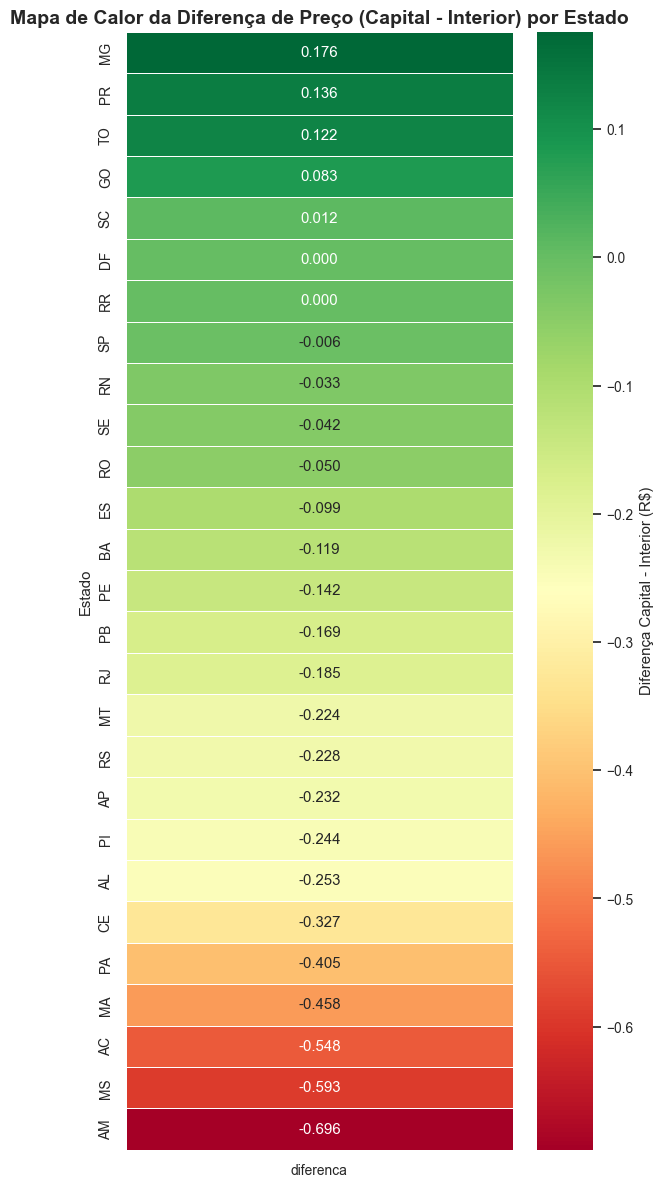

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Garantir que os dados estão em formato numérico
df_heat = df_diferenca.copy()
df_heat['diferenca'] = pd.to_numeric(df_heat['diferenca'], errors='coerce')
df_heat = df_heat.dropna(subset=['diferenca'])

# Ordenar por valor
df_heat = df_heat.sort_values('diferenca', ascending=False)
df_heat = df_heat.set_index('estado')

plt.figure(figsize=(6, 12))
sns.set(font_scale=0.9)

sns.heatmap(
    df_heat[['diferenca']],
    annot=True,
    fmt=".3f",
    cmap="RdYlGn",  # Vermelho para menor valor, verde para maior
    linewidths=0.4,
    cbar_kws={'label': 'Diferença Capital - Interior (R$)'}
)

plt.title("Mapa de Calor da Diferença de Preço (Capital - Interior) por Estado", fontsize=14, weight='bold')
plt.ylabel("Estado")
plt.xlabel("")
plt.tight_layout()
plt.show()


In [22]:
#insights: em mg os valores da capital costumam ser os maiores em relação ao interior, pq?
#no amapa costumam ser mais caros no interior do que na capital, pq?
#pq no df e no pr não tem diferença? pq nao teve dados dads cidades do interior e df seria brasilia, uma unica cidade.

In [23]:
# Análise 2 - consulta para gerar o valor de venda médio em capital e interior por região
consulta_dados ='''
SELECT
    l.regiao,
    l.estado,

    ROUND(AVG(cc.valor_venda), 3) AS preco_medio,
    COUNT(cc.valor_venda) AS frequencia,
    ROUND(STDDEV_SAMP(cc.valor_venda), 3) AS desvio_padrao,

    MIN(cc.valor_venda) AS minimo,
    MAX(cc.valor_venda) AS maximo

FROM combustiveiscomercializados cc
JOIN local l ON cc.id_local = l.id_local
GROUP BY l.regiao, l.estado
ORDER BY l.regiao, l.estado;




'''
df_dados = executar_consulta(consulta_dados)
df_dados


,regiao,estado,preco_medio,frequencia,desvio_padrao,minimo,maximo
0,CO,DF,5.683,4244,0.739,3.59,6.73
1,CO,GO,5.542,17308,0.905,3.28,7.19
2,CO,MS,5.775,5554,0.972,3.39,7.57
3,CO,MT,5.511,6841,1.064,3.19,7.05
4,N,AC,7.075,1898,0.891,4.69,7.95
5,N,AM,6.447,5118,0.895,4.27,8.09
6,N,AP,6.140,1413,0.453,4.56,7.89
7,N,PA,6.163,7081,0.729,3.89,7.40
8,N,RO,6.607,4372,0.622,4.41,8.04
9,N,RR,6.567,1744,0.441,4.79,7.08


In [24]:
# Análise 1 consulta para gerar o valor de venda médio em capital e interior por região
consulta_dados ='''
SELECT 
    cc.produto,
    cc.tipo_localidade,
    l.regiao,
    ROUND(AVG(cc.valor_venda), 3) AS valor_venda_medio
FROM 
    combustiveiscomercializados cc
JOIN 
    local l ON cc.id_local = l.id_local
GROUP BY 
    cc.produto, cc.tipo_localidade, l.regiao
ORDER BY 
    cc.produto, cc.tipo_localidade, l.regiao;
'''
df_dados = executar_consulta(consulta_dados)
df_dados


,produto,tipo_localidade,regiao,valor_venda_medio
0,DIESEL,Capital,CO,5.871
1,DIESEL,Capital,N,6.548
2,DIESEL,Capital,NE,5.870
3,DIESEL,Capital,S,5.853
4,DIESEL,Capital,SE,5.896
5,DIESEL,Interior,CO,6.007
6,DIESEL,Interior,N,6.509
7,DIESEL,Interior,NE,6.064
8,DIESEL,Interior,S,5.991
9,DIESEL,Interior,SE,5.929


In [32]:
#consulta sem tipo_localidade
# Análise 1: consulta para gerar o valor de venda médio por produto e região
consulta_dados = '''
SELECT 
    cc.produto,
    l.regiao,
    ROUND(AVG(cc.valor_venda), 3) AS valor_venda_medio
FROM 
    combustiveiscomercializados cc
JOIN 
    local l ON cc.id_local = l.id_local
GROUP BY 
    cc.produto, l.regiao
ORDER BY 
    cc.produto, l.regiao;
'''
df_dados = executar_consulta(consulta_dados)
df_dados


,produto,regiao,valor_venda_medio
0,DIESEL,CO,5.970
1,DIESEL,N,6.524
2,DIESEL,NE,6.043
3,DIESEL,S,5.985
4,DIESEL,SE,5.926
5,DIESEL S10,CO,6.039
6,DIESEL S10,N,6.491
7,DIESEL S10,NE,6.039
8,DIESEL S10,S,6.066
9,DIESEL S10,SE,6.033


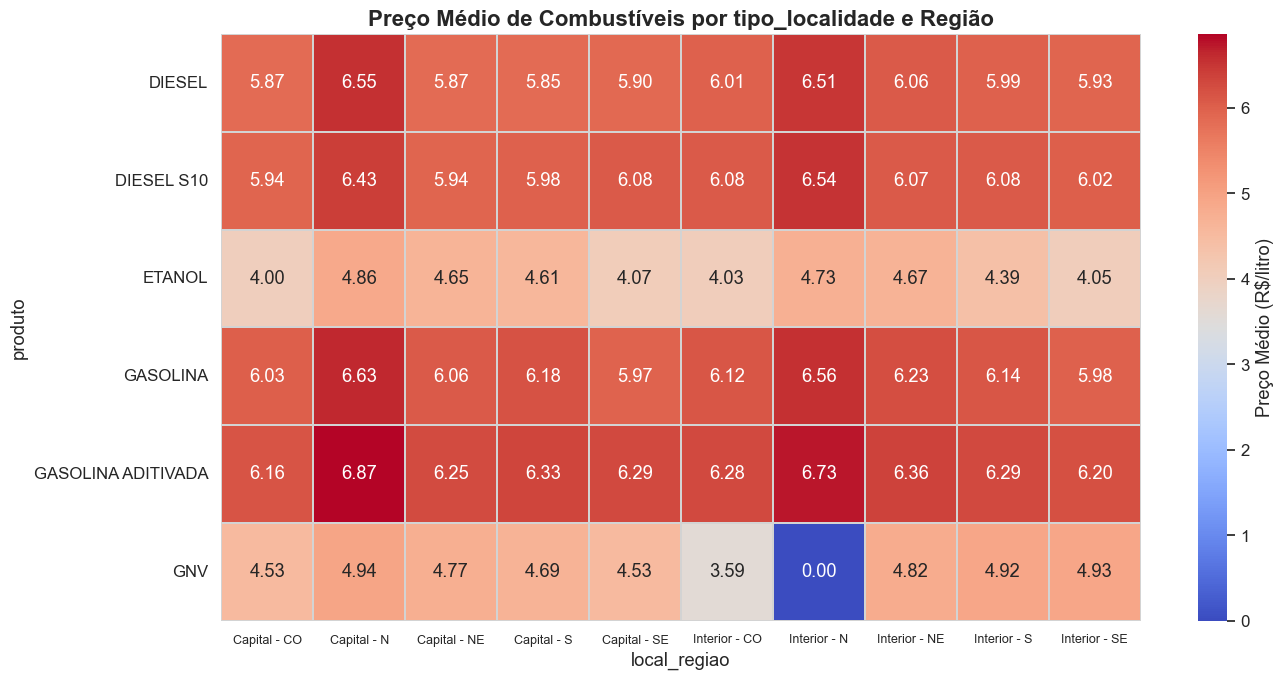

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Agrupamento
df_agg = (
    df_completo
    .groupby(['produto', 'tipo_localidade', 'regiao'])['valor_venda']
    .mean()
    .reset_index()
)

# Coluna combinada
df_agg['local_regiao'] = df_agg['tipo_localidade'] + ' - ' + df_agg['regiao']

# Pivot
heatmap_data = df_agg.pivot(index='produto', columns='local_regiao', values='valor_venda')
heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce').fillna(0)
heatmap_data = heatmap_data[sorted(heatmap_data.columns)]

plt.figure(figsize=(14, 7))
sns.set(style="white", font_scale=1.1)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.3,
    linecolor='lightgray',
    cbar_kws={'label': 'Preço Médio (R$/litro)'}
)

plt.title("Preço Médio de Combustíveis por tipo_localidade e Região", fontsize=16, weight='bold')
plt.xticks(rotation=0, fontsize=9)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [26]:
# insights: 
# No Norte os preços de venda dos combustíveis foram mais altos que os preços das demais regiões, porque?
# O etanol e o GNV tem os preços mais baixos dentre os combustíveis, porque?
# Gasolina aditivada atingiu a maior média de preço dentre os outros, principalmente no norte porque?
# Porque os outros mantiveram mais ou menos parecidos os valores nas outras regiões?

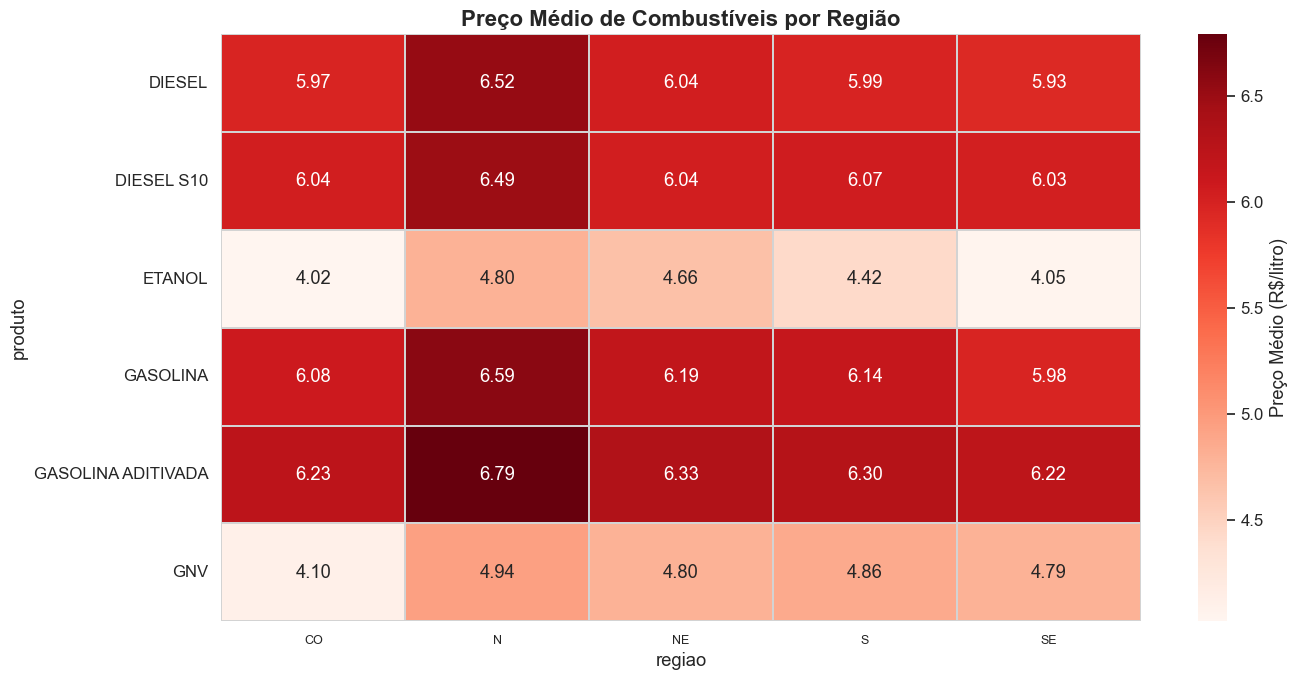

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Agrupamento apenas por produto e regiao
df_agg = (
    df_completo
    .groupby(['produto', 'regiao'])['valor_venda']
    .mean()
    .reset_index()
)

# Pivot para formar a matriz do heatmap
heatmap_data = df_agg.pivot(index='produto', columns='regiao', values='valor_venda')
heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce').fillna(0)
heatmap_data = heatmap_data[sorted(heatmap_data.columns)]  # Ordena as colunas por nome da região

# Plot
plt.figure(figsize=(14, 7))
sns.set(style="white", font_scale=1.1)

sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="Reds",  # <- Aqui define o degradê azul
    linewidths=0.3,
    linecolor='lightgray',
    cbar_kws={'label': 'Preço Médio (R$/litro)'}
)

plt.title("Preço Médio de Combustíveis por Região", fontsize=16, weight='bold')
plt.xticks(rotation=0, fontsize=9)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



In [28]:
#insights:
#tendo a analise por regiao a gente verificou que o etanol e o gnv são os mais baratos sendo o etanol na região CO
# A Gasolina aditivada costuma ser a mais cara
#a região norte é a mais cara de todos.

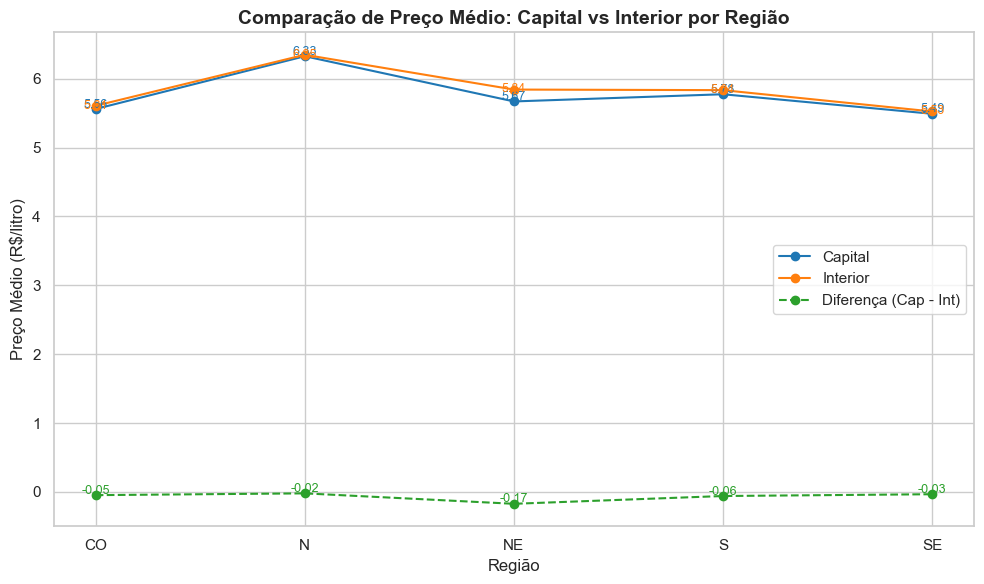

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supondo que você já tenha um DataFrame com a média de preços por região e tipo_localidade
# Se não tiver, agrupamos assim:
df_diff = (
    df_completo
    .groupby(['regiao', 'tipo_localidade'])['valor_venda']
    .mean()
    .reset_index()
)

# Pivot para colocar Capital e Interior como colunas
df_diff_pivot = df_diff.pivot(index='regiao', columns='tipo_localidade', values='valor_venda').reset_index()

# Calcula a diferença: Capital - Interior
df_diff_pivot['diferenca'] = df_diff_pivot['Capital'] - df_diff_pivot['Interior']

# Ordenar pelas regiões (opcional)
df_diff_pivot = df_diff_pivot.sort_values('regiao')

# Plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

plt.plot(df_diff_pivot['regiao'], df_diff_pivot['Capital'], marker='o', label='Capital', color='#1f77b4')
plt.plot(df_diff_pivot['regiao'], df_diff_pivot['Interior'], marker='o', label='Interior', color='#ff7f0e')
plt.plot(df_diff_pivot['regiao'], df_diff_pivot['diferenca'], marker='o', linestyle='--', label='Diferença (Cap - Int)', color='#2ca02c')

# Anota os valores nos pontos
for i, row in df_diff_pivot.iterrows():
    plt.text(row['regiao'], row['Capital'] + 0.02, f"{row['Capital']:.2f}", ha='center', fontsize=9, color='#1f77b4')
    plt.text(row['regiao'], row['Interior'] - 0.04, f"{row['Interior']:.2f}", ha='center', fontsize=9, color='#ff7f0e')
    plt.text(row['regiao'], row['diferenca'] + 0.02, f"{row['diferenca']:.2f}", ha='center', fontsize=9, color='#2ca02c')

# Títulos e ajustes
plt.title("Comparação de Preço Médio: Capital vs Interior por Região", fontsize=14, weight='bold')
plt.ylabel("Preço Médio (R$/litro)")
plt.xlabel("Região")
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
#insights:
#maior diferença no NE
# os valores de todos os combustíveis são mais caros no interior de todas as regiões
# No N teve a menor difenrença

In [31]:
consulta_dados ='''
SELECT 
    l.estado,
    ROUND(AVG(CASE WHEN cc.tipo_localidade = 'Capital' THEN cc.valor_venda END), 3) AS preco_capital,
    ROUND(AVG(CASE WHEN cc.tipo_localidade = 'Interior' THEN cc.valor_venda END), 3) AS preco_interior,
    ROUND(
        AVG(CASE WHEN cc.tipo_localidade = 'Capital' THEN cc.valor_venda END) -
        AVG(CASE WHEN cc.tipo_localidade = 'Interior' THEN cc.valor_venda END), 3
    ) AS diferenca
FROM 
    combustiveiscomercializados cc
JOIN 
    local l ON cc.id_local = l.id_local
WHERE 
    cc.produto = 'GNV'
    AND l.regiao = 'Norte'
GROUP BY 
    l.estado
ORDER BY 
    diferenca DESC;


'''
df_dados = executar_consulta(consulta_dados)
df_dados

,estado,preco_capital,preco_interior,diferenca
